# Numerical solution of IVPs - theory

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

As we recently learned, SciPy has a nice `odeint` tool that allows us to solve an initial value problem numerically. Let's review that real quick before we investigate how it might work. In the following code, I guess we're solving the IVP:
$$y' = t+t^2-\frac{1}{10}y^3, \: \: y(0)=0.$$
As far as I know, this equation has no simple, analytic solution.
Not only will we plot the solution, but we'll also plot the slopefield for the ODE.

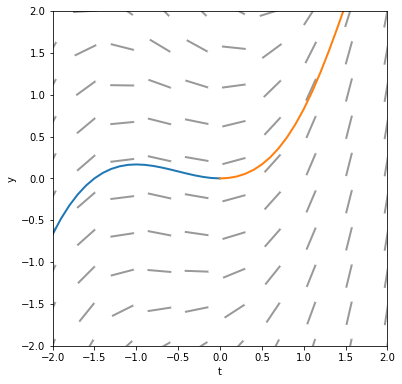

In [2]:
# Set up and solve the IVP in forward and backward directions
r = 2
def f(y,t): return t+t**2 - y**3/10
ts_p = np.linspace(0,r,21)
sol_p = odeint(f,0,ts_p)
ts_m = np.linspace(0,-r, 21)
sol_m = odeint(f,0,ts_m)

# Plot the solution
plt.plot(ts_m,sol_m, linewidth=2)
plt.plot(ts_p,sol_p, linewidth=2)

# Do a whole lot more work to plot the slopefield
T,Y = np.meshgrid( np.linspace(-r,r,10),np.linspace(-r,r,10) )
U = 1
V = f(Y,T)
N = np.sqrt(U**2+V**2)
U2, V2 = U/N, V/N
plt.quiver(T,Y,U2, V2, 
    headwidth=0, units='xy', scale=2.5, pivot='middle', 
    alpha=0.4)
ax=plt.gca()
ax.set_xlim(-r,r)
ax.set_ylim(-r,r)
ax.set_aspect(1)
ax.set_xlabel("t")
ax.set_ylabel("y")
fig = ax.get_figure()
fig.set_figheight(8)

## Euler's method
Euler's method is the most basic method for solving an IVP - just follow the slope field. In quantitative terms, if we are trying to draw the graph of the solution of $y'=f(y,t)$ and we know that $(t_k,y_k)$ is on the graph, then we can generate a point $(t_{k+1},y_{k+1})$ (approximately) on the graph by 
$$t_{k+1} = t_k + dt \: \text{ and } \: y_{k+1} = y_{k} + f(y_k,t_k)dt.$$
Note that second equation literally says that
$$y'(t_k) = f(y_k,t_k) \approx \frac{y_{k+1}-y_k}{dt},$$
i.e., the derivative is approximated by the difference quotient. So, this is pretty simple conceptually. It's also pretty easy to implement. Let's try it for the equation above and plot it together with the `odeint` solution.

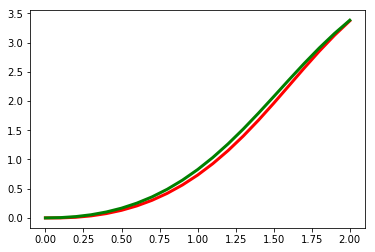

In [3]:
t0 = 0
y0 = 0
tn = t0
yn = y0
dt = 0.1
ts = [t0]
ys = [y0]
for i in range(10*r):
    yn = yn + f(yn,tn)*dt
    tn = tn + dt
    ys.append(yn)
    ts.append(tn)
plt.plot(ts,ys, 'r', linewidth=3)
plt.plot(ts_p,sol_p, 'g', linewidth=3)

Not bad! Let's plot the difference.

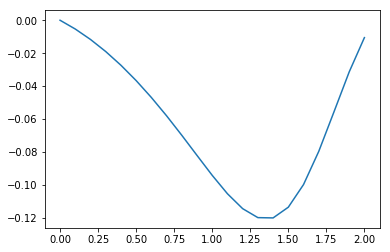

In [4]:
plt.plot(ts,ys-sol_p.ravel())

## Throwing off Euler's method
It's not too terribly hard to throw Euler's method off. Consider the following IVP.
$$
\begin{align}
 y' &= 4\pi y^2 \\
 y(0) &= -1
\end{align}
$$
There is one semi-stable equilibrium solution, $y(t)=0$, as we can easily see from the slope field.  Solutions below this equilibrium should increase up to the equilibrium. Let's apply Euler's method with a step size of $0.1$ and see what happens.

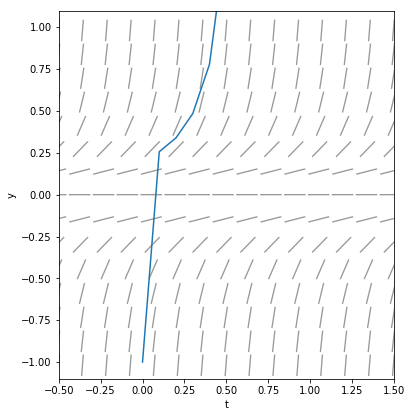

In [5]:
# The right hand side of the ODE:
def f(y,t): return 4*np.pi*y**2

# Plot the slopefield
T,Y = np.meshgrid( np.linspace(-0.5,1.5,15),np.linspace(-1,1,15) )
V = f(Y,T)
N = np.sqrt(1**2+V**2)
U2, V2 = 1/N, V/N
plt.quiver(T,Y,U2, V2, 
    headwidth=0, units='xy', scale=6, pivot='middle', 
    alpha=0.4)
ax=plt.gca()
ax.set_xlim(-0.5,1.5)
ax.set_ylim(-1,1)
ax.set_aspect(1)
ax.set_xlabel("t")
ax.set_ylabel("y")
fig = ax.get_figure()
fig.set_figheight(8)

# Euler's method:
t0 = 0
y0 = -1
tn = t0
yn = y0
dt = 0.1
ts = [t0]
ys = [y0]
for i in range(10):
    yn = yn + f(yn,tn)*dt
    tn = tn + dt
    ys.append(yn)
    ts.append(tn)
plt.plot(ts,ys)
ax = plt.gca()
ax.set_ylim(-1.1,1.1);

Uh-oh - we jumped right over the equlibrium solution. Generally, the error associated with Euler's method decreases with decreasing stepsize. Still, this seems like something to be aware of.

## Throwing off `odeint`
Surely, `odeint` must be immune to our attemps to mess with it. Well, let's try to solve
$$
\begin{align}
 y' &= y^2 - 2 \\
 y(0) &= \sqrt{2}.
\end{align}
$$
Clearly the solution should be constant, since $y(t)=\sqrt{2}$ is an equilibrium solution.

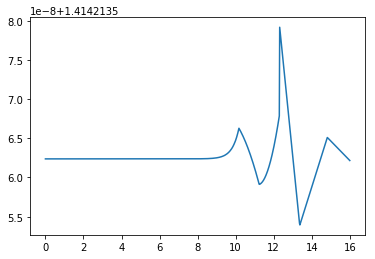

In [6]:
def f(y,t): return y**2 - 2
ts = np.linspace(0,16,800)
ys = odeint(f,np.sqrt(2),ts)
plt.plot(ts,ys);

Crazy! The deal is that, while $\sqrt{2}$ is an equilibrium, it is an *unstable* equilibrium. You can see this easily enough in the slope field.

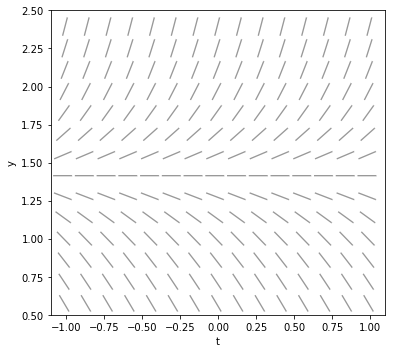

In [7]:
T,Y = np.meshgrid( np.linspace(-1,1,15), np.linspace(np.sqrt(2)-1,np.sqrt(2)+1,15))
V = f(Y,T)
N = np.sqrt(1**2+V**2)
U2, V2 = 1/N, V/N
plt.quiver(T,Y,U2, V2, 
    headwidth=0, units='xy', scale=6, pivot='middle', 
    alpha=0.4)
ax=plt.gca()
ax.set_ylim(0.5,2.5)
ax.set_aspect(1)
ax.set_xlabel("t")
ax.set_ylabel("y")
fig = ax.get_figure()
fig.set_figheight(8)

## A basic error estimate

We would like some idea as to how far off Euler's method can be when using it to approximate the solution to

$$y'=f(t,y)\\
\\
y\left(t_0\right)=y_0$$

We first figure out how much error is introduced in each step of the Euler method. That is, suppose we already know $y_n$ and we compute $y_{n+1}$
by

$$t_{n+1}=t_n+\Delta \, t\\
\\
y_{n+1}=y_n+f\left(t_n,y_n\right)\Delta \, t$$

Recall that $y_{n+1}$ is our approximation of $y\left(t_{n+1}\right)$. Expanding $y$ out in a Taylor series about $t_n$ we get

$$y\left(t_{n+1}\right) = y\left(t_n\right)+y'\left(t_n\right)\Delta \, t + \frac{1}{2}y''\left(t_n\right)\Delta \, t^2+\frac{1}{3!}y'''\left(t_n\right)\Delta
\, t^3+\cdots$$

Note that the error is

$$y\left(t_{n+1}\right) -y_{n+1}=y\left(t_{n+1}\right)-\left( y\left(t_n\right)+y'\left(t_n\right)\Delta \, t \right)= \frac{1}{2}y''\left(t_n\right)\Delta
\, t^2+\frac{1}{3!}y'''\left(t_n\right)\Delta \, t^3+\cdots$$

Thus, the error is proportional to $\Delta \, t^2$.
Now, if we apply Euler's method over an interval $[a,b]$, then we take approximately $(b-a)/\Delta t$ steps. Thus the final error is proportional
to $\Delta \, t$. In particular, the error approaches $0$ with the step size.

### Improving Euler's method

It's easy to write an ODE in terms of an integral because, if $y(t)$ solves $y'=f(t,y)$, then
$$\int_{t_k}^{t_{k+1}} y'(t) \, dt = \int_{t_k}^{t_{k+1}} f(t,y) \, dt$$
or
$$y(t_{k+1}) - y(t_k) = \int_{t_k}^{t_{k+1}} f(t,y) \, dt$$
so
$$y(t_{k+1}) = y(t_k) + \int_{t_k}^{t_{k+1}} f(t,y) \, dt.$$
In terms of recursion, this can be written
$$y_{k+1} = y_k + \int_{t_k}^{t_{k+1}} f(t,y) \, dt.$$
As a result, the process of stepping from one $y_k$ to the next is basically a process of numerical integration. Euler's method boils down to stating that
$$\int_{t_k}^{t_{k+1}} f(t,y) \, dt \approx f(t_k,y_k)(t_{k+1}-t_k).$$
If we use a better numerical integration technique, we obtain a better numerical ODE solver.

These techniques are called *Runge-Kutta methods*.
If we use Simpson's rule as the numerical integration technique, we obtain the fourth-order Runge-Kutta method which is very widely used.


## Euler's method for systems
This is not much harder than the situation that we had for single equations. Suppose we have

$$
\begin{align}
 x' &= f(x,y,t) \\
 y' &= g(x,y,t)
\end{align}
$$
subject to $x(t_0)=x_0$ and $y(t_0)=y_0$. We simply update from $(x_{i-1},y_{i-1})$ to $(x_i,y_i)$ via

$$
\begin{align}
  x_i &= x_{i-1} + f(x_{i-1},y_{i-1},t_{i-1})\Delta t \\
  y_i &= y_{i-1} + g(x_{i-1},y_{i-1},t_{i-1})\Delta t.
\end{align}
$$

As an example, suppose we want to estimate the solution to the autonomous, linear system

$$
\begin{align}
 x' &= y-x/2 \\
 y' &= -x-y/3
\end{align}
$$

subject to $x(0)=-2$ and $y(0)=2$. 

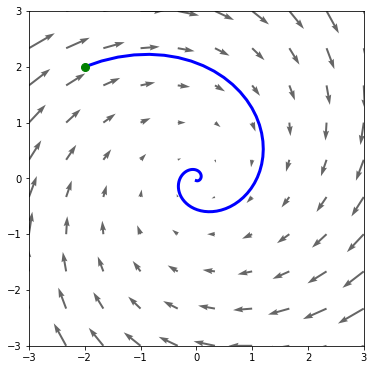

In [8]:
def f(x,y): return y-x/2
def g(x,y): return -x-y/3

X,Y = np.meshgrid( np.linspace(-3,3,10),np.linspace(-3,3,10) )
U = f(X,Y)
V = g(X,Y)
plt.quiver(X,Y,U, V, alpha=0.6)

t0 = 0
x0 = -2
y0 = 2
tn,xn,yn = (t0,x0,y0)
ts = [tn]
xs = [xn]
ys = [yn]
dt = 0.1
for i in range(100):
    xn = xn + f(xn,yn)*dt
    yn = yn + g(xn,yn)*dt
    tn = tn + dt
    xs.append(xn)
    ys.append(yn)
    ts.append(tn)
plt.plot(xs,ys, 'b', linewidth=3)
plt.plot(x0,y0, 'go', markersize=8)

ax=plt.gca()
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_aspect(1)
fig = ax.get_figure()
fig.set_figheight(8)